In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
raw_df = pd.read_csv('data/SE_rents2018_train.csv', index_col=0)

raw_test_df = pd.read_csv('data/SE_rents2018_test1.csv', index_col=0)


# Data Summarize

In [3]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.199900e+04,1.200000e+04,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,10723.000000
mean,1.529133e+06,1.657667,1.239500,850.465750,10682.779667,40.727507,-73.956837,2.370093e+06,2.287120e+09,10.266608,...,0.271667,0.170000,0.264083,0.208583,0.073167,0.132083,0.090500,3605.762917,0.490000,6.182738
std,4.301123e+06,1.079771,0.560208,515.773101,593.370964,0.053241,0.043024,1.242919e+06,1.202105e+09,12.019787,...,0.444837,0.375648,0.440862,0.406313,0.260421,0.338595,0.286909,2897.069446,0.499921,7.671545
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.141570,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.209200e+04,1.000000,1.000000,610.000000,10023.000000,40.693256,-73.986076,1.052139e+06,1.011220e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.495815e+05,2.000000,1.000000,800.000000,11103.000000,40.729028,-73.961700,3.019358e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.225132e+05,2.000000,1.000000,1000.000000,11218.000000,40.764599,-73.936663,3.326098e+06,3.050580e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877210e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.010640e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [4]:
raw_df.shape

(12000, 38)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 7236931 to 7422694
Data columns (total 38 columns):
addr_unit                 11909 non-null object
building_id               12000 non-null int64
bedrooms                  12000 non-null int64
bathrooms                 12000 non-null float64
size_sqft                 12000 non-null float64
created_at                12000 non-null object
addr_street               12000 non-null object
addr_city                 12000 non-null object
addr_zip                  12000 non-null int64
addr_lat                  12000 non-null float64
addr_lon                  12000 non-null float64
bin                       11999 non-null float64
bbl                       12000 non-null int64
floor_count               12000 non-null float64
year_built                11597 non-null float64
min_to_subway             11874 non-null float64
has_doorman               12000 non-null int64
has_elevator              12000 non-null int64
has_fireplace    

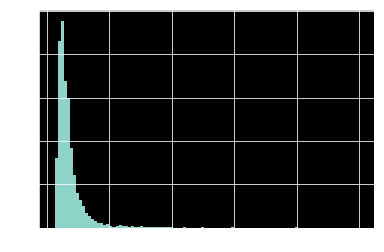

In [6]:
raw_df['rent'].hist(bins=100)

### Seperate all features into continuous, categorical and binary features.

For those none relatived features, we have excluded them from the features grouping: 
- addr_unit: no relationship
- building_id: no relationship
- addr_city: hard to encode
- addr_zip: hard to encode
- addr_street: hard to process
- neighborhood: hard to encode
- line: hard to encode
- bin: no relationship
- bbl: no relationshio
- description: hard to build a NLP model
- unit: no relationship


In [92]:
continuous_features =['bathrooms','bedrooms','size_sqft','floor_count','year_built','min_to_subway','floornumber', 'addr_lat', 'addr_lon']
categorical_features =['borough']
binary_features = ['has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets', 
                   'has_washer_dryer','has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
                   'has_childrens_playroom', 'no_fee', ]




In [8]:
unique_count = [] 
for feature in raw_df.columns:
  unique_count.append(raw_df[feature].nunique())
count_df = pd.DataFrame({'Feature':raw_df.columns,'unique count': unique_count})
count_df

,Feature,unique count
0,addr_unit,2192
1,building_id,7127
2,bedrooms,9
3,bathrooms,10
4,size_sqft,1256
5,created_at,11708
6,addr_street,7122
7,addr_city,37
8,addr_zip,149
9,addr_lat,6517


### use pair coorelation for continuous features

In [9]:
continuous_df = raw_df[continuous_features+['rent']]
continuous_df.corr()['rent'][:-1]

bathrooms        0.611987
bedrooms         0.353337
size_sqft        0.649984
floor_count      0.253517
year_built      -0.001037
min_to_subway    0.000010
floornumber      0.267151
Name: rent, dtype: float64

### Check coorelation for binary features



In [11]:
raw_df[binary_features+['rent']].corr()['rent'][:-1]
coor_results= []

for feature in binary_features:
  df = raw_df.groupby([feature]).aggregate(['mean'])['rent']
  df[feature]= df.index
  coor_results.append(df.corr().iloc[0][1])
coor_df = pd.DataFrame({'Coorelation': coor_results,'Feature':binary_features})
coor_df

,Coorelation,Feature
0,1.0,has_doorman
1,1.0,has_elevator
2,1.0,has_fireplace
3,1.0,has_dishwasher
4,1.0,is_furnished
5,1.0,has_gym
6,1.0,allows_pets
7,1.0,has_washer_dryer
8,1.0,has_garage
9,1.0,has_roofdeck


As we can see in the correlation table, all binrary features highly affected the rents. When we build the models, we should include all binary features.

### Check coorelation for categorical features
Need to do the binary first, then check the coorelation for categorical features, should be doen by group two

# Data Cleaning

### Handling missing data
In order to handle missing data in this dataset, we frist find and count all the null values.

In [10]:
raw_df.isna().sum()

addr_unit                   91
building_id                  0
bedrooms                     0
bathrooms                    0
size_sqft                    0
created_at                   0
addr_street                  0
addr_city                    0
addr_zip                     0
addr_lat                     0
addr_lon                     0
bin                          1
bbl                          0
floor_count                  0
year_built                 403
min_to_subway              126
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
has_garden                   0
has_childrens_playroom       0
rent                         0
no_fee                       0
descript

As we can see from the result,there are missing data appearing on: 
- addr_unit
- bin 
- year_built 
- min_to_subway 
- description 
- neighborhood 
- unit 
- floornumber 
- line 

Base on our data exploration, we can see that in this case, all features beside year_built,min_to_subway,neighborhood,and floornumber has not much impact to our final result, thus we don't need to worry about them.

Then, we will be dropping the rows which we don't have values for year_built, min_to_subway, neighborhood, and floornumber.

In [16]:
# We will call the new df md_df

md_df = raw_df.loc[
    raw_df.year_built.notnull() &
    raw_df.min_to_subway.notnull() & 
    raw_df.neighborhood.notnull() & 
    raw_df.floornumber.notnull()
]

# Reminder:
# use mode to replace NAN value, compare both method when creating models
# md_df = raw_df.loc[
#     raw_df.year_built.notnull() &
#     raw_df.min_to_subway.notnull() & 
#     raw_df.neighborhood.notnull() & 
# ]

# md_df['floornumber'].fillna(md_df['floornumber'].mode()[0], inplace=True)


print("original shape of dataset:",raw_df.shape)
print("shape of dataset after handling missing data:",md_df.shape)

original shape of dataset: (12000, 38)
shape of dataset after handling missing data: (10219, 38)


## remove outliers

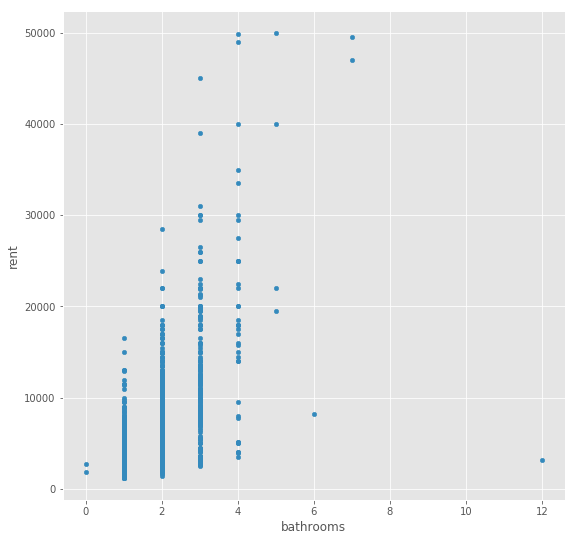

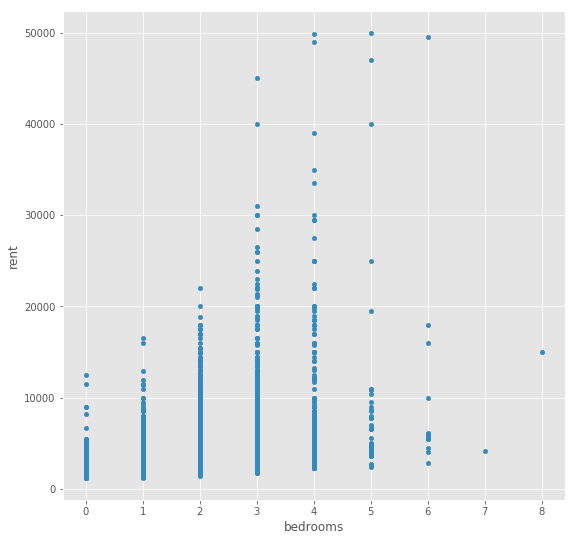

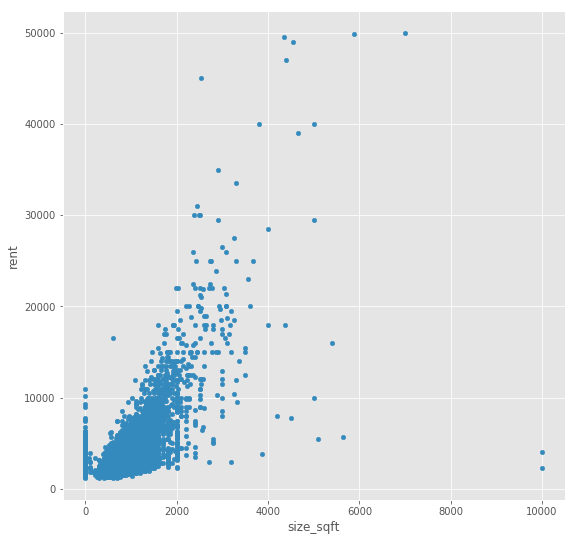

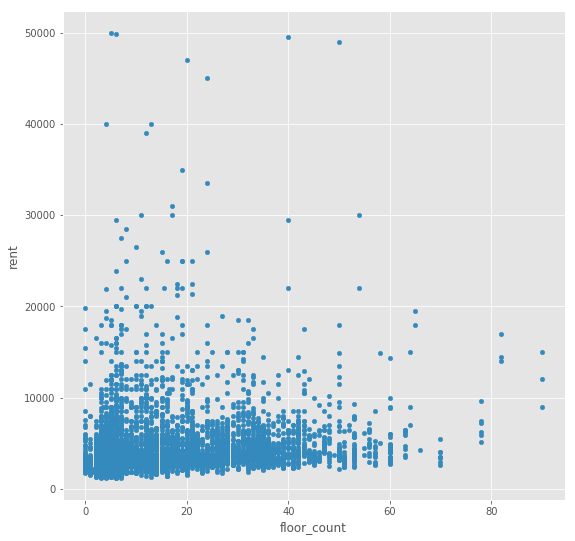

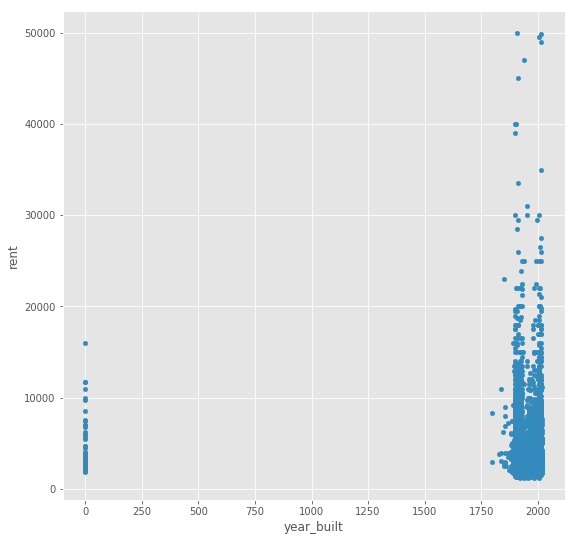

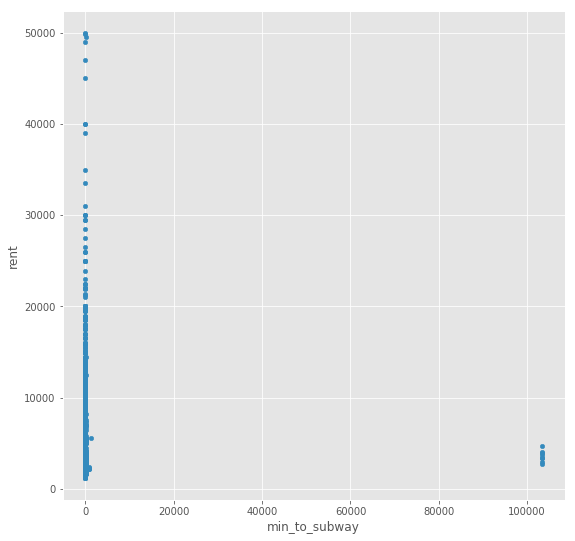

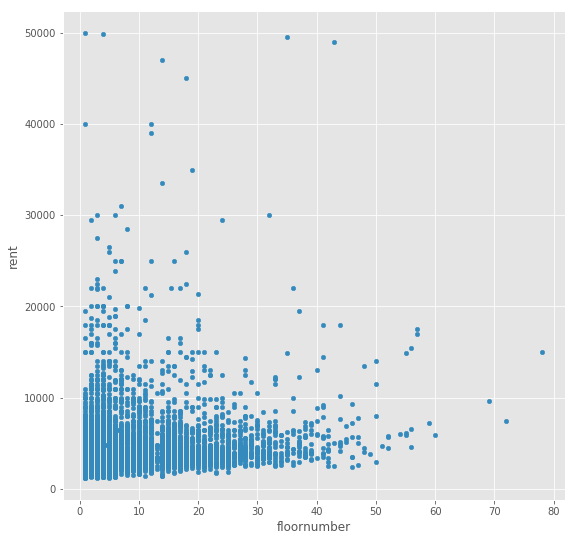

In [22]:
for feature in continuous_features:
    md_df.plot.scatter(feature, 'rent')

In [78]:
md_df.loc[md_df['size_sqft']==0].shape

(713, 38)

## drop size_sqrt = 0 for now, since there are 713 rows, might replace with mode when creating models

In [17]:
def remove_outliers(md_df, feature, low_value, high_value):
    print(feature, ': ', md_df.shape)
    md_df = md_df[md_df[feature]>low_value]
    md_df = md_df[md_df[feature]<=high_value]
    md_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', md_df.shape)
    return md_df

md_df = remove_outliers(md_df, 'rent', 0, 30000)
md_df = remove_outliers(md_df, 'bathrooms', 0, 12)
md_df = remove_outliers(md_df, 'size_sqft', 0, 10000)
md_df = remove_outliers(md_df, 'floor_count', 0, 80)
md_df = remove_outliers(md_df, 'year_built', 1700, 2019)
md_df = remove_outliers(md_df, 'min_to_subway', 0, 60)
md_df = remove_outliers(md_df, 'floornumber', 0, 60)

md_df['year_built'] = 2019 - md_df['year_built'].astype(int)

rent :  (10219, 38)
rent :  (10207, 38)
bathrooms :  (10207, 38)
bathrooms :  (10205, 38)
size_sqft :  (10205, 38)
size_sqft :  (9493, 38)
floor_count :  (9493, 38)
floor_count :  (9420, 38)
year_built :  (9420, 38)
year_built :  (9398, 38)
min_to_subway :  (9398, 38)
min_to_subway :  (9387, 38)
floornumber :  (9387, 38)
floornumber :  (9385, 38)


## encode categorical feature and drop useless features

In [18]:
boroughs = np.array(md_df['borough'].value_counts().index)

for borough in boroughs:
    md_df[borough] = md_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

md_df = md_df.drop(features_notNeed, axis=1)
md_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
bedrooms,0.000000,3.000000,1.000000,3.000000,3.000000,1.000000,0.000000,1.000000,1.000000,4.000000
bathrooms,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
size_sqft,475.000000,1886.000000,827.000000,1200.000000,850.000000,960.000000,400.000000,688.000000,550.000000,1800.000000
addr_lat,40.716599,40.755402,40.751301,40.681132,40.750807,40.761398,40.757301,40.711102,40.826092,40.705316
addr_lon,-74.004799,-73.967598,-73.986298,-73.944678,-73.879478,-73.996597,-73.967201,-73.953003,-73.942791,-73.916655
floor_count,17.000000,33.000000,24.000000,4.000000,3.000000,14.000000,43.000000,6.000000,3.000000,2.000000
year_built,5.000000,6.000000,0.000000,88.000000,89.000000,3.000000,29.000000,7.000000,93.000000,89.000000
min_to_subway,3.233300,3.050000,2.000000,2.133300,3.350000,6.883300,1.216700,3.633300,2.916700,1.750000
has_doorman,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
has_elevator,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
